# Sites Recommendation (Yelp dataset)


* [Introduction](#introduction)
* [Data](#data)
* [Preprocessing Data](#preprocessing-data) 
    * [Get Dummies from attributes](#get-dummies) 
* [Content Based Filtering Model](#content-based)
    * [K-nearest neighbours](#knn)       
* [Collaboritive Filtering - Model](#collaboritive)
    * [SVD - Singular Value Decomposition](#svd)  
        - [Building a Utility Matrix](#u-matrix)
        - [Transposing the Matrix](#transpose-matrix)
        - [Decomposing the Matrix](#decompose-matrix)
        - [Generating a correlation Matrix](#gen-corr-matrix)  
        - [Isolating the most popular restaurant from the Correlation Matrix](#isolate)
        - [Recommend highly correlated Restaurants](#recommend)                   
    * [Neural Network - keras](#NN-keras)    
        - [Prediction](#prediction)
        - [Cosine similarity](#cos-similarity)
        - [Recommendation](#recommendation)

<a id="introduction"></a>
# Introduction

In this notebook, we are building a recommender system using Yelp Dataset. In order to build this system, we had two main approaches which are Content-Based Filtering and Collaborative Filtering. 

> * **Content-Based Filtering:** It is based on the features of the restaurants rather than the user features. The idea is if the user likes a restaurant then he/she will like the other similar restaurants.
>  
> * **Collaborative Filtering:** It is based on the assumption that people like restaurants similar to other restaurants they like, and restaurants that are liked by other people with similar tastes.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('C:/Users/sam79/OneDrive/桌面/W210 Yelp/data'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\non_food_merged.csv
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_academic_dataset_business.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_academic_dataset_checkin.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_academic_dataset_review.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_academic_dataset_tip.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_academic_dataset_user.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_dataset.tar
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_dataset\yelp_academic_dataset_business.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_dataset\yelp_academic_dataset_review.json
C:/Users/sam79/OneDrive/桌面/W210 Yelp/data\yelp_dataset\yelp_dataset


<a id="data"></a>
# Data

We are using subsets of each table since we have a large dataset to work with. For this notebook, we used _business_ and _review_ tables.

In [2]:
# import the data (chunksize returns jsonReader for iteration)
# businesses = pd.read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=1000000)
# reviews = pd.read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=1000000)

In [3]:
# import the data (chunksize returns jsonReader for iteration)
businesses = pd.read_json("./data/yelp_academic_dataset_business.json", lines=True, orient='columns', chunksize=1000000)
reviews = pd.read_json("./data/yelp_academic_dataset_review.json", lines=True, orient='columns', chunksize=1000000) # Total is 8.2 M reviews
# users = pd.read_json("./data/yelp_academic_dataset_user.json", lines=True, orient='columns', chunksize=10000000)

In [4]:
# read the data 
for business in businesses:
    subset_business = business
    break
    
for review in reviews:
    subset_review = review
    break

# for user in users:
#     subset_user = user
#     break

In [5]:
# peak the tables
display(subset_business.head(2))
display(subset_review.head(2))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [6]:
print(subset_business.shape)
print(subset_review.shape)
# print(subset_user.shape)

(150346, 14)
(1000000, 9)


C:\Users\sam79\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Star Ratings ')

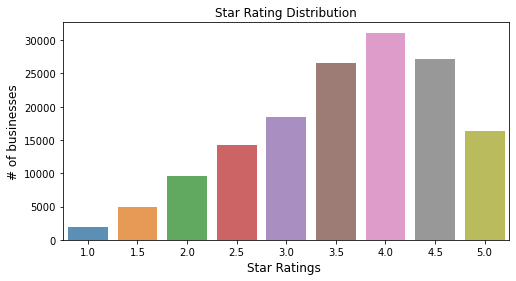

In [7]:
x=subset_business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

C:\Users\sam79\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


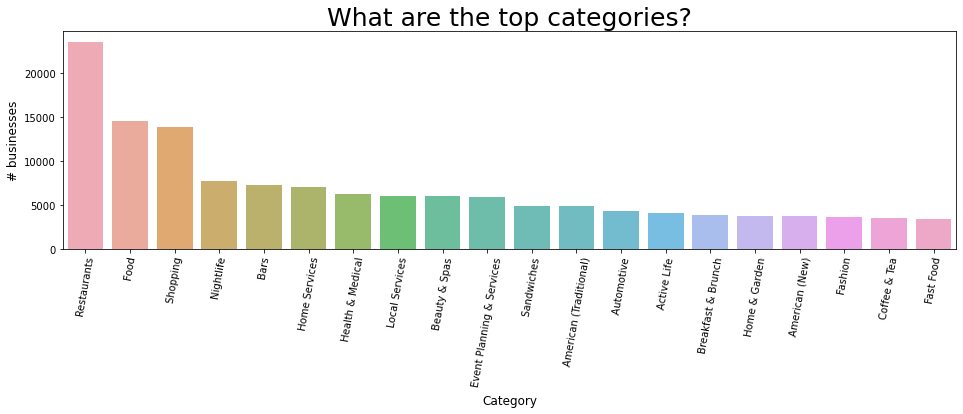

In [8]:
business_cats = ''.join(subset_business['categories'].astype('str'))

cats=pd.DataFrame(business_cats.split(','),columns=['categories'])

#prep for chart
x=cats.categories.value_counts()

x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

C:\Users\sam79\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'City')

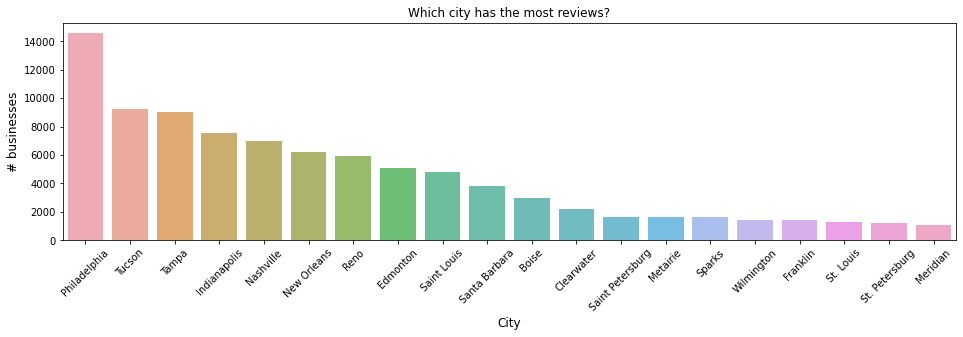

In [9]:
#Get the distribution of the ratings
x=subset_business['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

In [10]:
# No New York, Maybe in other Naming convention ?
subset_business[(subset_business['city'].str.contains('New'))]['city'].value_counts()

New Orleans         6209
New Port Richey      604
Newark               359
Newtown              322
New Hope             246
New Castle           217
Newtown Square       176
New Britain           17
Newport               14
New Palestine         13
New Whiteland          6
Newfield               6
New Washoe City        4
New orleans            2
New Tampa              1
Newtown Sq.            1
Newtown Sqaure         1
Newcastle              1
Newtown Sq             1
New Britian            1
Newportville           1
Newtown Township       1
Newton Square          1
New Orlaens            1
Newtown square         1
New Berlinville        1
New Pt Richey          1
New Jersey             1
New Prt Rchy           1
New castle             1
Newton                 1
Name: city, dtype: int64

In [11]:
# No San Diego and San Francisco, Maybe in other Naming convention ?
subset_business[(subset_business['city'].str.contains('San'))]['city'].value_counts()

Santa Barbara                       3829
San Antonio                           14
Santa Barbara                          5
Sanatoga                               3
Santa Barbra                           2
Santa Ynez                             1
Santa Clara                            1
Santa Rita                             1
San Anselmo                            1
Santa Barbara,                         1
Santa Barbara & Ventura Counties       1
Santa  Barbara                         1
Santa Maria                            1
Name: city, dtype: int64

In [12]:
# No Paris, Maybe in other Naming convention ?
subset_business[(subset_business['city'].str.contains('Paris'))]['city'].value_counts()

Jefferson Parish    1
Name: city, dtype: int64

In [13]:
subset_business['city'].value_counts().sort_values(ascending=False)

Philadelphia    14569
Tucson           9250
Tampa            9050
Indianapolis     7540
Nashville        6971
                ...  
Spark               1
Sullivan            1
St Boise            1
Merion              1
Apollo beach        1
Name: city, Length: 1416, dtype: int64

### Non-food Sites

In [14]:
# Select locations which are categorized as Shopping, Nightlife, Home Services, Health & Medical, Local Services, Beauty & Spas, Event Planning & Services, Automotive, Active Life, Home & Garden, Fashion
Non_food = subset_business[(subset_business['categories'].str.contains('Shopping')) | (subset_business['categories'].str.contains('Nightlife')) | (subset_business['categories'].str.contains('Home Services'))| (subset_business['categories'].str.contains('Health & Medical'))| (subset_business['categories'].str.contains('Local Services'))| (subset_business['categories'].str.contains('Beauty & Spas'))| (subset_business['categories'].str.contains('Event Planning & Services'))| (subset_business['categories'].str.contains('Automotive'))| (subset_business['categories'].str.contains('Active Life'))| (subset_business['categories'].str.contains('Home & Garden'))| (subset_business['categories'].str.contains('Fashion'))]
Non_food = Non_food[(subset_business['is_open'] == 1)]
print(Non_food.shape)
Non_food.head()

(79267, 14)


C:\Users\sam79\AppData\Local\Temp/ipykernel_16804/412284527.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Non_food = Non_food[(subset_business['is_open'] == 1)]


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
10,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.457380,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Department Stores, Shopping, Fashion","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
13,jaxMSoInw8Poo3XeMJt8lQ,Adams Dental,15 N Missouri Ave,Clearwater,FL,33755,27.966235,-82.787412,5.0,10,1,{'ByAppointmentOnly': 'True'},"General Dentistry, Dentists, Health & Medical,...","{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3..."
16,rBmpy_Y1UbBx8ggHlyb7hA,Arizona Truck Outfitters,625 N Stone Ave,Tucson,AZ,85705,32.229872,-110.972342,4.5,10,1,"{'DriveThru': 'False', 'BusinessAcceptsCreditC...","Automotive, Auto Parts & Supplies, Auto Custom...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '..."


C:\Users\sam79\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Category')

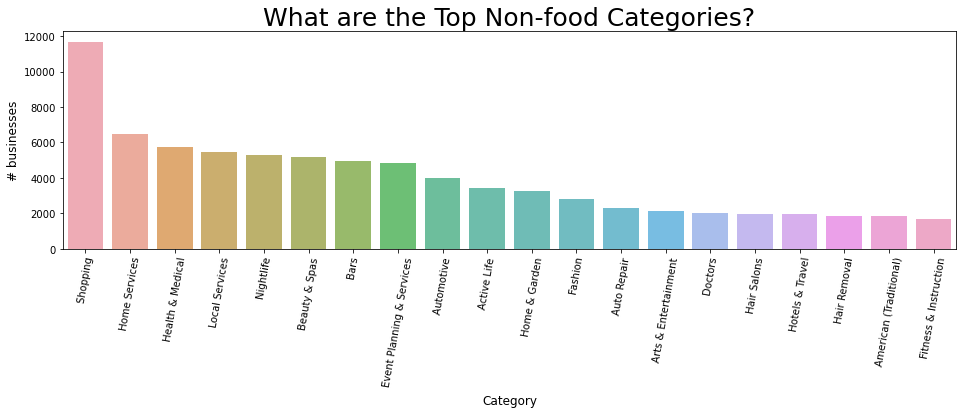

In [15]:
#prep for chart
Non_food_cats = ''.join(Non_food['categories'].astype('str'))

cats=pd.DataFrame(Non_food_cats.split(','),columns=['categories'])

x=cats.categories.value_counts()
x = x.drop([' Restaurants',' Food'])

x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("What are the Top Non-food Categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

In [16]:
print('Shopping Locations:')
display(Non_food[(Non_food['categories'].str.contains('Shopping'))].head())
print('Home Services Locations:')
display(Non_food[(Non_food['categories'].str.contains('Home Services'))].head())
print('Health & Medical Locations:')
display(Non_food[(Non_food['categories'].str.contains('Health & Medical'))].head())

Shopping Locations:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
10,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.457380,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","Department Stores, Shopping, Fashion","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
17,M0XSSHqrASOnhgbWDJIpQA,Herb Import Co,712 Adams St,New Orleans,LA,70118,29.941468,-90.129953,4.0,5,1,"{'BusinessParking': '{'garage': False, 'street...","Vape Shops, Tobacco Shops, Personal Shopping, ...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
21,qhDdDeI3K4jy2KyzwFN53w,Barnes & Noble Booksellers,8675 River Crossing Blvd,Indianapolis,IN,46240,39.913820,-86.105739,4.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Shopping, Books, Mags, Music & Video, Bookstores","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
26,noByYNtDLQAra9ccqxdfDw,H&M,827-833 State St,Santa Barbara,CA,93101,34.420209,-119.700460,3.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Women's Clothing, Accessories, Children's Clot...","{'Monday': '11:0-18:0', 'Tuesday': '11:0-18:0'..."


Home Services Locations:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
51,REwfwz-_-CMQ7Np5UVi9Qg,Jennie Deckert,,Carmel,IN,46032,39.969300,-86.165002,5.0,7,1,None,"Real Estate Agents, Home Services, Real Estate",None
84,eMjnw_7wp-CscyNh6Lu0ZA,AM&PM Locksmith,8540 Bustleton Ave,Philadelphia,PA,19152,40.072330,-75.048483,4.5,58,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Keys & Locksmiths, Home Services, Local Services","{'Monday': '6:0-3:0', 'Tuesday': '6:0-3:0', 'W..."
94,ZM46RDLXaFNo_z6t-j_L4w,Absolutely Perfect Inc,1153 Byberry Rd,Bensalem,PA,19020,40.113121,-74.914597,3.5,5,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessA...","Masonry/Concrete, Gardeners, Lawn Services, Tr...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ..."
98,U2Tzy6J9aAAg9pzXsgdkvg,Premier Mortgage Resources,"3363 E Presidential Dr, Ste 200",Meridian,ID,83642,43.614194,-116.352500,5.0,6,1,None,"Real Estate, Home Services, Financial Services...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
107,2n9HHBxG7yAyAUwXXa49aw,Mighty Dustless,1256 Valley Hill Trl,Southampton,PA,18966,40.169021,-75.009316,4.0,5,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessA...","Flooring, Handyman, Contractors, Home Services","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:0', '..."


Health & Medical Locations:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
13,jaxMSoInw8Poo3XeMJt8lQ,Adams Dental,15 N Missouri Ave,Clearwater,FL,33755,27.966235,-82.787412,5.0,10,1,{'ByAppointmentOnly': 'True'},"General Dentistry, Dentists, Health & Medical,...","{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3..."
43,Kq51_lGAgAigqmENITTr-A,Bala Better Health,"2 Bala Plz, Ste PL-11",Bala Cynwyd,PA,19004,40.006870,-75.217262,4.0,13,1,"{'WiFi': 'u'free'', 'BusinessAcceptsBitcoin': ...","Health & Medical, Beauty & Spas, Laser Hair Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0'}"
57,DQ7PyYlp2bX96WZa7TcaWQ,LensCrafters,"1150 Plymouth Meeting Mall, Ste 2230",Plymouth Meeting,PA,19462,40.116179,-75.282525,2.5,8,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Ophthalmologists, Eyewear & Opticians, Health ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
74,9Rww8yE6Dm4dSMEq09nwXg,Holly Nails & Spa,9101 Belcher Rd,Pinellas Park,FL,33782,27.855347,-82.736308,4.5,16,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Health & Medical, Personal Care Services, Beau...","{'Tuesday': '9:30-19:0', 'Wednesday': '9:30-19..."
100,8KMIT0NXu30Jz5Ojo5uxaw,Cornerstone Physical Therapy Associates,"1338 Bristol Pike, Ste 203",Bensalem,PA,19020,40.072204,-74.964420,5.0,6,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Fitness & Instruction, Physical Therapy, Healt...","{'Monday': '9:0-19:0', 'Tuesday': '9:0-15:30',..."


<a id="preprocessing-data"></a>
# Preprocessing the Data

We chose Philadelphia since it has the highest number of restraunts. The restaurant is the most popular category among businesses. 

In [17]:
# Businesses in Philadelphia and currently open business
city = subset_business[(subset_business['city'].str.contains('Philadelphia')) & (subset_business['is_open'] == 1)]
Philadelphia = city[['business_id','name','address', 'categories', 'attributes','stars']]
Philadelphia

,business_id,name,address,categories,attributes,stars
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'RestaurantsDelivery': 'False', 'OutdoorSeati...",4.0
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,"Sushi Bars, Restaurants, Japanese","{'RestaurantsReservations': 'True', 'Restauran...",4.0
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,"Korean, Restaurants","{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...",4.5
35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,"Eatertainment, Arts & Entertainment, Brewpubs,...","{'OutdoorSeating': 'True', 'RestaurantsPriceRa...",3.5
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,"Restaurants, Automotive, Delis, Gas Stations, ...","{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...",3.0
...,...,...,...,...,...,...
150306,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,"Restaurants, Specialty Food, Food, Sandwiches,...","{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...",3.0
150326,JDM7kiCEmeBc_5W-z6eZZw,2601 Parkway Apartments,2601 Pennsylvania Ave,"Real Estate, Apartments, Home Services",{'BusinessAcceptsCreditCards': 'True'},3.0
150329,9U1Igcpe954LoWZRmNc-zg,Hand & Stone Massage And Facial Spa,"1100 S Columbus Blvd, Ste 24","Day Spas, Beauty & Spas, Skin Care, Massage","{'BusinessAcceptsCreditCards': 'True', 'Wheelc...",3.0
150334,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,"1638 Pine St, Fl 1","Health & Medical, Yoga, Shopping, Naturopathic...","{'ByAppointmentOnly': 'True', 'GoodForKids': '...",4.5


In [18]:
# getting just restaurants from Philadelphia business
rest = Philadelphia[Philadelphia['categories'].str.contains('Restaurant.*')==True].reset_index()
rest

,index,business_id,name,address,categories,attributes,stars
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'RestaurantsDelivery': 'False', 'OutdoorSeati...",4.0
1,15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,"Sushi Bars, Restaurants, Japanese","{'RestaurantsReservations': 'True', 'Restauran...",4.0
2,19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,"Korean, Restaurants","{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...",4.5
3,35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,"Eatertainment, Arts & Entertainment, Brewpubs,...","{'OutdoorSeating': 'True', 'RestaurantsPriceRa...",3.5
4,82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,"Restaurants, Automotive, Delis, Gas Stations, ...","{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...",3.0
...,...,...,...,...,...,...,...
3526,150178,auwFZzfhe2pvFw43OfsAfw,Stina Pizzeria,1705 Snyder Ave,"Pizza, Restaurants, Mediterranean","{'DogsAllowed': 'False', 'RestaurantsTakeOut':...",4.5
3527,150210,K1SsvIPfFcHniNSPc3IG7g,Flip-N-Pizza,1308 W Girard Ave,"Restaurants, American (Traditional), Chicken W...","{'WiFi': 'u'no'', 'BYOB': 'False', 'Restaurant...",4.0
3528,150237,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,3306 Arch St,"Specialty Food, Event Planning & Services, Res...","{'BikeParking': 'True', 'WheelchairAccessible'...",3.0
3529,150306,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,"Restaurants, Specialty Food, Food, Sandwiches,...","{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...",3.0


<a id="get-dummies"></a>
* ** Get Dummies from attributes and categories columns**

> In "attributes" column has nested attributes. In order to create a feature table, we need to separate those nested attributes into their own columns. Therefore, the following functions will be used to achieve this goal.

In [19]:
# Function that extract keys from the nested dictionary
def extract_keys(attr, key):
    if attr == None:
        return "{}"
    if key in attr:
        return attr.pop(key)

# convert string to dictionary
import ast
def str_to_dict(attr):
    if attr != None:
        return ast.literal_eval(attr)
    else:
        return ast.literal_eval("{}")    

In [20]:
# get dummies from nested attributes
rest['BusinessParking'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'BusinessParking')), axis=1)
rest['Ambience'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Ambience')), axis=1)
rest['GoodForMeal'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'GoodForMeal')), axis=1)
rest['Dietary'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Dietary')), axis=1)
rest['Music'] = rest.apply(lambda x: str_to_dict(extract_keys(x['attributes'], 'Music')), axis=1)

In [21]:
rest

,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'RestaurantsDelivery': 'False', 'OutdoorSeati...",4.0,"{'garage': False, 'street': True, 'validated':...",{},{},{},{}
1,15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,"Sushi Bars, Restaurants, Japanese","{'RestaurantsReservations': 'True', 'Restauran...",4.0,"{'valet': False, 'garage': None, 'street': Tru...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': True, 'latenight': None, 'lunch': ...",{},{}
2,19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,"Korean, Restaurants","{'NoiseLevel': 'u'quiet'', 'RestaurantsGoodFor...",4.5,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
3,35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,"Eatertainment, Arts & Entertainment, Brewpubs,...","{'OutdoorSeating': 'True', 'RestaurantsPriceRa...",3.5,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}
4,82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,"Restaurants, Automotive, Delis, Gas Stations, ...","{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...",3.0,"{'garage': False, 'street': True, 'validated':...","{'romantic': False, 'intimate': False, 'classy...",{},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...
3526,150178,auwFZzfhe2pvFw43OfsAfw,Stina Pizzeria,1705 Snyder Ave,"Pizza, Restaurants, Mediterranean","{'DogsAllowed': 'False', 'RestaurantsTakeOut':...",4.5,"{'valet': False, 'garage': None, 'street': Tru...","{'divey': False, 'hipster': None, 'casual': Tr...","{'dessert': None, 'latenight': None, 'lunch': ...",{},{}
3527,150210,K1SsvIPfFcHniNSPc3IG7g,Flip-N-Pizza,1308 W Girard Ave,"Restaurants, American (Traditional), Chicken W...","{'WiFi': 'u'no'', 'BYOB': 'False', 'Restaurant...",4.0,{},{},{},{},{}
3528,150237,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,3306 Arch St,"Specialty Food, Event Planning & Services, Res...","{'BikeParking': 'True', 'WheelchairAccessible'...",3.0,{},{},{},{},{}
3529,150306,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,"Restaurants, Specialty Food, Food, Sandwiches,...","{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...",3.0,"{'garage': False, 'street': True, 'validated':...","{'touristy': None, 'hipster': False, 'romantic...","{'dessert': False, 'latenight': False, 'lunch'...",{},{}


In [22]:
# create table with attribute dummies
df_attr = pd.concat([rest['attributes'].apply(pd.Series), rest['BusinessParking'].apply(pd.Series),
                    rest['Ambience'].apply(pd.Series), rest['GoodForMeal'].apply(pd.Series), 
                    rest['Dietary'].apply(pd.Series) ], axis=1)
df_attr_dummies = pd.get_dummies(df_attr)
df_attr_dummies

,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,BikeParking_False,...,latenight_False,latenight_True,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,brunch_True,breakfast_False,breakfast_True
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
3,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
4,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3527,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3528,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3529,0,0,1,1,0,0,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0


In [23]:
rest_attribute = rest['attributes'].apply(pd.Series)
rest_attribute

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,...,BestNights,Smoking,DriveThru,BYOB,CoatCheck,Open24Hours,AcceptsInsurance,AgesAllowed,DietaryRestrictions,RestaurantsCounterService
0,False,False,False,True,1,True,False,u'free',u'none',True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,True,NaN,2,True,NaN,'free','full_bar',NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,True,True,1,True,NaN,u'no',u'none',True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,True,NaN,2,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,False,True,True,1,True,False,u'free',u'none',False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526,True,True,True,NaN,2,True,NaN,NaN,u'none',NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3527,True,False,True,True,NaN,True,NaN,u'no',u'none',True,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
3528,NaN,NaN,True,True,NaN,True,NaN,NaN,u'beer_and_wine',True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3529,True,False,True,True,2,True,NaN,'no',u'none',True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most attributes reflect facilities and service of a restaurant

In [24]:
rest_business_parking = rest['BusinessParking'].apply(pd.Series)
rest_business_parking

,garage,street,validated,lot,valet
0,False,True,False,False,False
1,None,True,None,False,False
2,False,True,False,False,False
3,False,False,False,True,False
4,False,True,False,False,False
...,...,...,...,...,...
3526,None,True,False,False,False
3527,NaN,NaN,NaN,NaN,NaN
3528,NaN,NaN,NaN,NaN,NaN
3529,False,True,False,True,False


Business parking features reflect parking related information

In [25]:
rest_ambience = rest['Ambience'].apply(pd.Series)
rest_ambience

,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,False,False,False,False,False,False,True,False
2,False,False,False,False,None,False,False,False,True
3,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
3526,None,None,None,False,None,True,False,None,True
3527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3529,None,False,False,False,False,False,False,False,True


Ambience features reflect the atmosphere of a restaurant

In [26]:
rest_goodformeal = rest['GoodForMeal'].apply(pd.Series)
rest_goodformeal

,dessert,latenight,lunch,dinner,brunch,breakfast
0,NaN,NaN,NaN,NaN,NaN,NaN
1,True,None,None,True,None,None
2,False,False,True,True,False,False
3,False,False,False,False,False,False
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3526,None,None,None,True,None,None
3527,NaN,NaN,NaN,NaN,NaN,NaN
3528,NaN,NaN,NaN,NaN,NaN,NaN
3529,False,False,True,True,False,False


GoodForMeal features reflects the availability of meals in a day

In [27]:
# get dummies from categories
df_categories_dummies = pd.Series(rest['categories']).str.get_dummies(',')
df_categories_dummies

,Acai Bowls,Active Life,Adult,Adult Entertainment,Afghan,African,Airport Lounges,Airport Shuttles,American (New),American (Traditional),...,Trinidadian,Turkish,Uzbek,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Wine Bars,Wineries,Wraps
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Based on the observation above, we may adopt categories and ambience to be the features and drop attributes, parking, good for meal features

In [28]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
display(df_categories_dummies)

,Acai Bowls,Active Life,Adult,Adult Entertainment,Afghan,African,Airport Lounges,Airport Shuttles,American (New),American (Traditional),Apartments,Appliances,Arabic,Arcades,Argentine,Armenian,Art Classes,Art Galleries,Arts & Crafts,Arts & Entertainment,Asian Fusion,Australian,Automotive,Axe Throwing,Bagels,Bakeries,Bangladeshi,Banks & Credit Unions,Barbeque,Barbers,Bars,Beaches,Beauty & Spas,Beer,Beer Bar,Beer Gardens,Belgian,Beverage Store,Boat Charters,Boat Tours,Boating,Books,Bookstores,Bowling,Brasseries,Brazilian,Breakfast & Brunch,Breweries,Brewpubs,British,Bubble Tea,Buffets,Burgers,Burmese,Business Consulting,Butcher,Cafes,Cafeteria,Cajun/Creole,Cambodian,Candle Stores,Candy Stores,Cannabis Clinics,Cannabis Dispensaries,Cantonese,Cards & Stationery,Caribbean,Casinos,Caterers,Cheese Shops,Cheesesteaks,Chicken Shop,Chicken Wings,Chinese,Chocolatiers & Shops,Cideries,Cocktail Bars,Coffee & Tea,Coffee Roasteries,Colleges & Universities,Colombian,Comedy Clubs,Comfort Food,Convenience Stores,Conveyor Belt Sushi,Cooking Classes,Cooking Schools,Cosmetics & Beauty Supply,Costumes,Creperies,Cuban,Cupcakes,Custom Cakes,Dance Clubs,Delicatessen,Delis,Dentists,Department Stores,Desserts,Dim Sum,Diners,Dinner Theater,Distilleries,Dive Bars,Do-It-Yourself Food,Doctors,Dominican,Donuts,Eatertainment,Education,Empanadas,Ethiopian,Ethnic Food,Event Planning & Services,Eyewear & Opticians,Falafel,Farmers Market,Fashion,Fast Food,Festivals,Filipino,Financial Advising,Financial Services,Fish & Chips,Fishing,Fitness & Instruction,Florists,Flowers & Gifts,Food,Food Court,Food Delivery Services,Food Stands,Food Trucks,French,Fruits & Veggies,Furniture Stores,Fuzhou,Gas Stations,Gastropubs,Gay Bars,Gelato,General Dentistry,Georgian,German,Gift Shops,Gluten-Free,Golf,Golf Lessons,Greek,Grocery,Hair Salons,Haitian,Halal,Hawaiian,Health & Medical,Health Markets,Himalayan/Nepalese,Historical Tours,Hobby Shops,Home & Garden,Home Decor,Home Services,Honduran,Hong Kong Style Cafe,Hookah Bars,Hospitals,Hot Dogs,Hot Pot,Hotels,Hotels & Travel,Hunting & Fishing Supplies,Iberian,Ice Cream & Frozen Yogurt,Imported Food,Indian,Indonesian,Indoor Playcentre,International Grocery,Internet Cafes,Irish,Irish Pub,Israeli,Italian,Izakaya,Japanese,Japanese Curry,Jazz & Blues,Jewelry,Juice Bars & Smoothies,Karaoke,Kebab,Kids Activities,Kitchen & Bath,Kitchen Supplies,Korean,Kosher,Landmarks & Historical Buildings,Laotian,Latin American,Lebanese,Live/Raw Food,Local Flavor,Local Services,Lounges,Mags,Malaysian,Mass Media,Massage,Massage Therapy,Meat Shops,Mediterranean,Men's Clothing,Mexican,Middle Eastern,Mini Golf,Modern European,Mongolian,Moroccan,Museums,Music & DVDs,Music & Video,Music Venues,Naturopathic/Holistic,New Mexican Cuisine,Newspapers & Magazines,Nightlife,Noodles,Nurseries & Gardening,Nutritionists,Organic Stores,Outdoor Gear,Paint & Sip,Pakistani,Pan Asian,Parks,Party & Event Planning,Party Equipment Rentals,Pasta Shops,Patisserie/Cake Shop,Performing Arts,Persian/Iranian,Personal Chefs,Peruvian,Pets,Pizza,Poke,Polish,Pool Halls,Pop-Up Restaurants,Portuguese,Poutineries,Pretzels,Print Media,Professional Services,Property Management,Public Markets,Public Services & Government,Public Transportation,Pubs,Puerto Rican,Ramen,Real Estate,Real Estate Agents,Recreation Centers,Religious Organizations,Restaurant Supplies,Restaurants,Russian,Salad,Salvadoran,Sandwiches,Sardinian,Seafood,Seafood Markets,Senegalese,Shanghainese,Shaved Ice,Shipping Centers,Shopping,Shopping Centers,Sicilian,Singaporean,Skating Rinks,Social Clubs,Soul Food,Soup,South African,Southern,Spanish,Speakeasies,Specialty Food,Specialty Schools,Sporting Goods,Sports Bars,Sports Betting,Sports Clubs,Steakhouses,Street Vendors,Strip Clubs,Supper Clubs,Sushi Bars,Swimming Pools,Szechuan,Tabletop Games,Tacos,Taiwanese,Tapas Bars,Tapas/Small Plates,Taxis,Tea Rooms,Tennis,Teppanyaki,Tex-Mex,Thai,Themed Cafes,Ticket Sales,Tiki Bars,Tobacco Shops,Tours,Toy Stores,Train Stations,Transportation,Trav

In [29]:
# pull out names and stars from rest table 
result = rest[['name','stars']]
result

,name,stars
0,St Honore Pastries,4.0
1,Tuna Bar,4.0
2,BAP,4.5
3,Craft Hall,3.5
4,Wawa,3.0
...,...,...
3526,Stina Pizzeria,4.5
3527,Flip-N-Pizza,4.0
3528,Grilly Cheese,3.0
3529,PrimoHoagies,3.0


In [30]:
# Concat all tables and drop Restaurant column
df_final = pd.concat([df_attr_dummies, df_categories_dummies, result], axis=1)
df_final.drop('Restaurants',inplace=True,axis=1)

In [31]:
# map floating point stars to an integer
mapper = {1.0:1,1.5:2, 2.0:2, 2.5:3, 3.0:3, 3.5:4, 4.0:4, 4.5:5, 5.0:5}
df_final['stars'] = df_final['stars'].map(mapper)

In [32]:
# Final table for the models 
df_final

,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,BikeParking_False,BikeParking_None,BikeParking_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,RestaurantsTakeOut_False,RestaurantsTakeOut_None,RestaurantsTakeOut_True,ByAppointmentOnly_False,ByAppointmentOnly_True,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_None,WiFi_u'free',WiFi_u'no',WiFi_u'paid',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',Caters_False,Caters_None,Caters_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,RestaurantsGoodForGroups_False,RestaurantsGoodForGroups_None,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',HasTV_False,HasTV_None,HasTV_True,GoodForKids_False,GoodForKids_None,GoodForKids_True,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',DogsAllowed_False,DogsAllowed_None,DogsAllowed_True,HappyHour_False,HappyHour_True,WheelchairAccessible_False,WheelchairAccessible_True,RestaurantsTableService_False,RestaurantsTableService_True,BusinessAcceptsBitcoin_False,BusinessAcceptsBitcoin_True,BYOBCorkage_'no',BYOBCorkage_'yes_corkage',BYOBCorkage_'yes_free',BYOBCorkage_None,BYOBCorkage_u'no',BYOBCorkage_u'yes_corkage',BYOBCorkage_u'yes_free',Corkage_False,Corkage_None,Corkage_True,GoodForDancing_False,GoodForDancing_True,BestNights_None,"BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday'

## Check how many attributes(Tags) in the dataset for restraunts for our recomendation algorithms

In [33]:
# Check how many attributes(Tags) for restraunts for our recomendation algorithms
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
df_final.head()

,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,BikeParking_False,BikeParking_None,BikeParking_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,RestaurantsTakeOut_False,RestaurantsTakeOut_None,RestaurantsTakeOut_True,ByAppointmentOnly_False,ByAppointmentOnly_True,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_None,WiFi_u'free',WiFi_u'no',WiFi_u'paid',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',Caters_False,Caters_None,Caters_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,RestaurantsGoodForGroups_False,RestaurantsGoodForGroups_None,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',HasTV_False,HasTV_None,HasTV_True,GoodForKids_False,GoodForKids_None,GoodForKids_True,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',DogsAllowed_False,DogsAllowed_None,DogsAllowed_True,HappyHour_False,HappyHour_True,WheelchairAccessible_False,WheelchairAccessible_True,RestaurantsTableService_False,RestaurantsTableService_True,BusinessAcceptsBitcoin_False,BusinessAcceptsBitcoin_True,BYOBCorkage_'no',BYOBCorkage_'yes_corkage',BYOBCorkage_'yes_free',BYOBCorkage_None,BYOBCorkage_u'no',BYOBCorkage_u'yes_corkage',BYOBCorkage_u'yes_free',Corkage_False,Corkage_None,Corkage_True,GoodForDancing_False,GoodForDancing_True,BestNights_None,"BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday'

In [34]:
# List out all attributes with values
df_final.drop(['name','stars'], axis =1).sum(axis=0).sort_values(ascending = False).tail(100)

Arcades                                                                                                                                             1
Art Galleries                                                                                                                                       1
Art Museums                                                                                                                                         1
Arts & Crafts                                                                                                                                       1
BestNights_{'monday': True, 'tuesday': True, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}             1
BestNights_{u'monday': False, u'tuesday': False, u'wednesday': False, u'thursday': False, u'friday': False, u'saturday': True, u'sunday': False}    1
 Restaurant Supplies                                                                                

<a id="content-based"></a>
# Content Based Filtering- Model

build a system that recognizes the similarity between restaurants based on specific features and recommends restaurants that are most similar to a particular restaurant. __df_final__ (features) table used to build this system.

<a id="knn"></a>
## 1. K-Nearest Neighbours model (KNN)
> 
>    - Split the data into train and test set  (80:20)
>    - Instantiate and fit the model
>    - Test the model: we used the last row as a validation set (we didn't include this last row to train the model)
>    - Recommend restaurants for the validation set (the last restaurant in the df_final table)

In [35]:
# Create X (all the features) and y (target)
X = df_final.iloc[:,:-2]
y = df_final['stars']

* **Split the data into train and test set (80:20)**

In [36]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.2, random_state=1)

* **Instantiate and fit the model**

In [37]:
y_train_knn.head()

3277    5
273     4
3224    3
558     5
3487    3
Name: stars, dtype: int64

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_knn, y_train_knn)

#y_pred = knn.predict(X_test)

accuracy_train = knn.score(X_train_knn, y_train_knn)
accuracy_test = knn.score(X_test_knn, y_test_knn)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

Score on training set: 0.5513456090651558
Score on test set: 0.4738330975954738


C:\Users\sam79\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\sam79\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

The restaurant of the validation set

In [39]:
# look at the last row for the test
display(df_final.iloc[-1:])

# look at the restaurant name from the last row.
print("Validation set (Restaurant name): ", df_final['name'].values[-1])

,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,BikeParking_False,BikeParking_None,BikeParking_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,RestaurantsTakeOut_False,RestaurantsTakeOut_None,RestaurantsTakeOut_True,ByAppointmentOnly_False,ByAppointmentOnly_True,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_None,WiFi_u'free',WiFi_u'no',WiFi_u'paid',Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_None,Alcohol_u'beer_and_wine',Alcohol_u'full_bar',Alcohol_u'none',Caters_False,Caters_None,Caters_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,RestaurantsGoodForGroups_False,RestaurantsGoodForGroups_None,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_'formal',RestaurantsAttire_None,RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',HasTV_False,HasTV_None,HasTV_True,GoodForKids_False,GoodForKids_None,GoodForKids_True,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_None,NoiseLevel_u'average',NoiseLevel_u'loud',NoiseLevel_u'quiet',NoiseLevel_u'very_loud',DogsAllowed_False,DogsAllowed_None,DogsAllowed_True,HappyHour_False,HappyHour_True,WheelchairAccessible_False,WheelchairAccessible_True,RestaurantsTableService_False,RestaurantsTableService_True,BusinessAcceptsBitcoin_False,BusinessAcceptsBitcoin_True,BYOBCorkage_'no',BYOBCorkage_'yes_corkage',BYOBCorkage_'yes_free',BYOBCorkage_None,BYOBCorkage_u'no',BYOBCorkage_u'yes_corkage',BYOBCorkage_u'yes_free',Corkage_False,Corkage_None,Corkage_True,GoodForDancing_False,GoodForDancing_True,BestNights_None,"BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': True, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': True, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': True, 'saturday': True}","BestNights_{'monday': False, 'tuesday': False, 'friday': True, 'wednesday': False, 'thursday': True, 'sunday': False, 'saturday'

Validation set (Restaurant name):  Adelita Taqueria & Restaurant


* **Test the model:** 

> We used the last row as a validation set (we didn't include this last row for modeling). 

In [40]:
# test set from the df_final table (only last row): Restaurant name: "Steak & Cheese & Quick Pita Restaurant"
test_set = df_final.iloc[-1:,:-2]

# validation set from the df_final table (exclude the last row)
X_val =  df_final.iloc[:-1,:-2]
y_val = df_final['stars'].iloc[:-1]

In [41]:
# fit model with validation set
n_knn = knn.fit(X_val, y_val)

After fitting the KNN model to the validation set, we are going to find the distances between the validation set and the other restaurants based on their similar features. 

In [42]:
# distances and indeces from validation set (Steak & Cheese & Quick Pita Restaurant)
distances, indeces =  n_knn.kneighbors(test_set)
#n_knn.kneighbors(test_set)[1][0]

# create table distances and indeces from "Steak & Cheese & Quick Pita Restaurant"
final_table = pd.DataFrame(n_knn.kneighbors(test_set)[0][0], columns = ['distance'])
final_table['index'] = n_knn.kneighbors(test_set)[1][0]
final_table.set_index('index')

,distance
index,
3119,4.000000
3098,4.123106
1785,4.123106
1195,4.242641
930,4.358899
3443,4.358899
1983,4.358899
1050,4.358899
586,4.472136


We are creating the following ***result*** table which displays similar restaurants to the validation restrauant by their distances. Based on this recommendation system, the short distance means having more similarity to the validation restrauant.

In [43]:
# get names of the restaurant that similar to the validation restrauant
result = final_table.join(df_final,on='index')
result[['distance','index','name','stars']].head(5)

,distance,index,name,stars
0,4.000000,3119,Los Taquitos de Puebla,4
1,4.123106,3098,Yummy Sushi,4
2,4.123106,1785,The Pizza Place,3
3,4.242641,1195,The Flavor Spot,4
4,4.358899,930,Artigiano Pizza,3


The problem of the Content-Based Filtering Method is that it doesn't capture any information about users' preferences since it only cares about restaurant features. Next, we will implement the Collaborative Filtering Methods.

<a id="collaboritive"></a>
# User Collaborative Filtering - Model

Use the Collaborative Filtering technique to make a recommendation to restaurant users. This algorithm is based on the idea that similar users can have a similar restaurant preference. 

We are implementing the following machine learning techniques to build a recommender system:
1. Singular Value Decomposition model (SVD)
2. Neural Network (Keras)

<a id="svd"></a>
## 1. Singular Value Decomposition model (SVD)

In [44]:
# looking at the columns of subset_review table
subset_review.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'], dtype='object')

In [45]:
subset_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [46]:
# pull out needed columns from subset_review table
df_review = subset_review[['user_id','business_id','stars', 'date']]
df_review

,user_id,business_id,stars,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,2018-07-07 22:09:11
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,2012-01-03 15:28:18
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,2014-02-05 20:30:30
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,2015-01-04 00:01:03
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,2017-01-14 20:54:15
...,...,...,...,...
999995,oX7o1TH0PHUWp9r9ry9_vw,jLn69WQupjsDKrbPw_nlGQ,3,2017-11-15 09:43:07
999996,v8wlapFKVLs2qTYCGhCdiw,t6v8g8UeNiq3O2GoEc7R4Q,4,2014-09-03 18:27:33
999997,rLlYc1RzIBnOmnX3AbpEYw,ZYRul0i1bhOjirHED6Kd0w,3,2016-02-20 22:25:29
999998,eEH-8CEPU5ndPxDGzVfHiQ,onGXKwnxPLtKnO8yqQMPSA,1,2010-06-27 02:17:30


In [47]:
# pull out names and addresses of the restaurants from rest table
restaurant = rest[['business_id', 'name', 'address']]
restaurant

,business_id,name,address
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St
...,...,...,...
3526,auwFZzfhe2pvFw43OfsAfw,Stina Pizzeria,1705 Snyder Ave
3527,K1SsvIPfFcHniNSPc3IG7g,Flip-N-Pizza,1308 W Girard Ave
3528,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,3306 Arch St
3529,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave


In [48]:
# combine df_review and restaurant table
combined_business_data = pd.merge(df_review, restaurant, on='business_id')
combined_business_data

,user_id,business_id,stars,date,name,address
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,2015-01-04 00:01:03,Zaika,2481 Grant Ave
1,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,2014-07-13 17:25:47,Zaika,2481 Grant Ave
2,mqBWACmaHflW4eh_Ofp16Q,kxX2SOes4o-D3ZQBkiMRfA,5,2010-08-20 19:16:04,Zaika,2481 Grant Ave
3,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5,2017-01-02 14:25:26,Zaika,2481 Grant Ave
4,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5,2015-07-28 17:15:20,Zaika,2481 Grant Ave
...,...,...,...,...,...,...
79395,Cn5dtFbUPfvPL04WGAyy4A,2f3YghoMYzd5-GFMh_kvwQ,5,2019-01-25 02:29:07,Del Frisco's Grille,225 S Broad St
79396,BUmhtxNc-9AEkvOnrQS-_Q,2f3YghoMYzd5-GFMh_kvwQ,4,2019-02-17 04:42:37,Del Frisco's Grille,225 S Broad St
79397,j2COG29Rqr4T_6kjEiOU7w,mzJ7BxxhLtm-TD1vyne1yg,5,2019-02-09 04:58:02,Neighborhood Ramen,617 S 3rd St
79398,5GMOJ3pT4-ye25qJocHX-Q,E0AKqwkebF15_hvzNSyGlQ,1,2018-10-11 17:04:38,P. J. Clarke's,601 Walnut St


In [49]:
# the most POPULAR restaurants by stars.
combined_business_data.groupby('business_id')['user_id'].nunique().sort_values(ascending=False).head()

business_id
EtKSTHV5Qx_Q7Aur9o4kQQ    1553
j-qtdD55OLfSqfsWuQTDJg    1404
cXSyVvOr9YRN9diDkaWs0Q    1396
S8ZFYEgMejpChID8tzKo9A    1288
vUrTGX_7HxqeoQ_6QCVz6g    1121
Name: user_id, dtype: int64

In [50]:
# the most active user with most number of reviews
combined_business_data.groupby('user_id')['business_id'].nunique().sort_values(ascending=False).head()

user_id
0DB3Irpf_ETVXu_Ou9vPow    57
ET8n-r7glWYqZhuR6GcdNw    53
8EMU7d4pCkdqUnvlIW40CA    52
hQjN1FuYaB4pQACZwfrclw    46
LnFIWZM_l__4t8Qxj3pnOg    45
Name: business_id, dtype: int64

In [51]:
# see the NAME of the most popular restaurant
Filter = combined_business_data['business_id'] == 'EtKSTHV5Qx_Q7Aur9o4kQQ'
print("Name: ", combined_business_data[Filter]['name'].unique())
print("Address:", combined_business_data[Filter]['address'].unique())

Name:  ['Village Whiskey']
Address: ['118 S 20th St']


The popular restaurant by ratings is **"Village Whiskey"**.

<a id="u-matrix"></a>
* **Building a Utility Matrix (User-Restaurant Matrix)**

This matrix contains each user, each restaurant, and the rating each user gave to each restaurant. Notice this matrix will be sparse because every user doesn't review every restaurant.

In [52]:
# create a user-item matrix
rating_crosstab = combined_business_data.pivot_table(values='stars', index='user_id', columns='name', fill_value=0)
rating_crosstab.head()

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,Applebee's Grill + Bar,Aqimero,Aramingo's Best Pizza,Arby's,Arbys Roast Beef,Asadero los tios,Asian Garden,Athenian Restaurant,Attico Rooftop Lounge,Au Bon Pain,Authentic LanZhou Handpulled Noodles,Axis Pizza,Aya's Pizza,B&B Breakfast and Lunch,BAP,BRÜ Craft & Wurst,Bai Wei,Bally Pizza,Baltic Bakery,Bank & Bourbon,Barnes & Noble Booksellers,Beck's Cajun Cafe,Beijing,Beijing Panda,Bellini,Benna's Cafe,Best In Town Pizza,Big Daddy Pizza,Big Geez Chicken Shack,Bistro La Baia,Bistro Romano,Bistrot La Minette,Bitar's,Bleu Sushi,Blue Corn,Bluestone Lane - Philadelphia,Bob's Diner,Bold Coffee Bar,Bonks Bar,Boom Buns,Boostin' Bowls,Boricua Restaurant,Boston Market,Bourbon & Branch,Branzino Italian Ristorante,Brauhaus Schmitz,Bread & Butter Philly - Breakfast Junction,Breakfast Boutique Chestnut Hill,Bridesburg Pizza,Brotherly Grub,Brown Sugar Bakery & Cafe,Bubblefish,Buca D’Oro,Buena Onda,Bui's,Buk Chon Korean Cuisine,Burger King,Burger Lane,Burrito Bonito,Butcher and Singer,Butter's Soul Food,By George! Pizza Pasta & Cheesesteaks,CYM Island Kitchen,Cactus Restaurant & Bar,Cadillac Grille,Cafe Cuong,Cafe Nhan,Cafe Square One,Café y Chocolate,Cake Life Bake Shop,Cantina Dos Segundos,Cantinho Brasileiro Restaurante,Capital Beer,Carangi Baking,Carmen's Famous Italian Hoagies,Castellino's,Cedar Park Cafe,Chan's Halal Restaurant,Chapterhouse Café & Gallery,Charlie Was a Sinner,Charlie's Roast Pork,Chase's Hop Shop,Checkers,Chef Joseph Poon,Cherry Lounge,Cheu Fishtown,Chick-fil-A,Chickie's & Pete's,Chickie's & Pete's Cafe,China House,China Royal,China Star,Chipotle Mexican Grill,Chopstick House,Chuck E. Cheese,Chuck's Alibi,Cily Chicken Rice,Cleopatra Cafe,Cloud Factory Hookah Lounge,Con Murphy's,Convenient Food Mart,Copabanana,Cosmic Café and Ciderhouse,Craft Hall,Craft Manayunk,Crazy Sushi,Creme Brulee Bistro & Cafe,Crown Fried Chicken,Cucina Italiana,Cucina Zapata,Currito,D'S Caribbean And American Food,DK Sushi,Dagwood's Pub,Daiki Hibachi and Sushi,Daiva's Grille,Daleng Restaurant,Day Break Eggs,Del Frisco's Grille,Devon Seafood Grill,Dolce Pizza,Domenic's Pizzeria,Domino's Pizza,Don Panchito Mexican Grill,Dragon House,Dream House Asian Bistro,Drinker's Tavern,Dunkin',Earl of Sandwich,East Coast Wings & Grill,Ecowas African Restaurant,Ed's Pizza House,Eddie's Pizza,Ekta Indian Cuisine,El Camino Real,El Guero Mexican Food Truck,El Limon,El Merkury,El Principe Restaurant,El Purepecha,El Sarape Restaurant,Emperor's Garden Chinese Restaurant,Essene Market & Café,Explorer's Den Steaks and Hoagies,Fabio's Chicken Restaurant Takeout,Falls Deli,Federal Donuts,Feltonville Express Pizza,Fez Moroccon Restaurant,Fino's Pizzeria & Restaurant,Fitzwater Street Philly Bagels,Flambo Caribbean Restaurant,Flaming Basil,Flannel,Fogo de Chao,Foodery,Foods On First,Forin Cafe,Fortune Chinese Restaurant,Frank's Spaghetti House,Franklin's,Franny Lou's Porch,Franzone's Pizzeria & Restaurant,Freddy & Tony's Restaurant,Fredy & Tony's Restaurant,Fresh Gulf Seafood,Fruit Salad Cart,Fu-Wah Mini Market,Gaby’s Station Pizza,Gachi Sushi and Noodle,Gaetano’s,Gennaro's Famous Pizza,George's Food truck,George's Sandwich Shop,George's Wings,Gigi and Big R,Gilben's Bakery,Giovanni's Pizzeria,Golden China Wok Restaurant,Golden Chopstick Chinese Restaurant,Golden Gates,Golden Triangle,Goldie,Good Day Eatery,Good Dog Bar,Good Karma Cafe,Goody's Pizza,Gooey Looie's,Goree,Great Wall Chinese Restaurant,Greek Lady,Green Basil Thai Kitchen,Green Eggs Cafe,Green Garden,Green

In [53]:
# Perform a random Check on one restaurant and see whether we have ratings in place
rating_crosstab[rating_crosstab['1 Stop Pizza']!=0].head()

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,Applebee's Grill + Bar,Aqimero,Aramingo's Best Pizza,Arby's,Arbys Roast Beef,Asadero los tios,Asian Garden,Athenian Restaurant,Attico Rooftop Lounge,Au Bon Pain,Authentic LanZhou Handpulled Noodles,Axis Pizza,Aya's Pizza,B&B Breakfast and Lunch,BAP,BRÜ Craft & Wurst,Bai Wei,Bally Pizza,Baltic Bakery,Bank & Bourbon,Barnes & Noble Booksellers,Beck's Cajun Cafe,Beijing,Beijing Panda,Bellini,Benna's Cafe,Best In Town Pizza,Big Daddy Pizza,Big Geez Chicken Shack,Bistro La Baia,Bistro Romano,Bistrot La Minette,Bitar's,Bleu Sushi,Blue Corn,Bluestone Lane - Philadelphia,Bob's Diner,Bold Coffee Bar,Bonks Bar,Boom Buns,Boostin' Bowls,Boricua Restaurant,Boston Market,Bourbon & Branch,Branzino Italian Ristorante,Brauhaus Schmitz,Bread & Butter Philly - Breakfast Junction,Breakfast Boutique Chestnut Hill,Bridesburg Pizza,Brotherly Grub,Brown Sugar Bakery & Cafe,Bubblefish,Buca D’Oro,Buena Onda,Bui's,Buk Chon Korean Cuisine,Burger King,Burger Lane,Burrito Bonito,Butcher and Singer,Butter's Soul Food,By George! Pizza Pasta & Cheesesteaks,CYM Island Kitchen,Cactus Restaurant & Bar,Cadillac Grille,Cafe Cuong,Cafe Nhan,Cafe Square One,Café y Chocolate,Cake Life Bake Shop,Cantina Dos Segundos,Cantinho Brasileiro Restaurante,Capital Beer,Carangi Baking,Carmen's Famous Italian Hoagies,Castellino's,Cedar Park Cafe,Chan's Halal Restaurant,Chapterhouse Café & Gallery,Charlie Was a Sinner,Charlie's Roast Pork,Chase's Hop Shop,Checkers,Chef Joseph Poon,Cherry Lounge,Cheu Fishtown,Chick-fil-A,Chickie's & Pete's,Chickie's & Pete's Cafe,China House,China Royal,China Star,Chipotle Mexican Grill,Chopstick House,Chuck E. Cheese,Chuck's Alibi,Cily Chicken Rice,Cleopatra Cafe,Cloud Factory Hookah Lounge,Con Murphy's,Convenient Food Mart,Copabanana,Cosmic Café and Ciderhouse,Craft Hall,Craft Manayunk,Crazy Sushi,Creme Brulee Bistro & Cafe,Crown Fried Chicken,Cucina Italiana,Cucina Zapata,Currito,D'S Caribbean And American Food,DK Sushi,Dagwood's Pub,Daiki Hibachi and Sushi,Daiva's Grille,Daleng Restaurant,Day Break Eggs,Del Frisco's Grille,Devon Seafood Grill,Dolce Pizza,Domenic's Pizzeria,Domino's Pizza,Don Panchito Mexican Grill,Dragon House,Dream House Asian Bistro,Drinker's Tavern,Dunkin',Earl of Sandwich,East Coast Wings & Grill,Ecowas African Restaurant,Ed's Pizza House,Eddie's Pizza,Ekta Indian Cuisine,El Camino Real,El Guero Mexican Food Truck,El Limon,El Merkury,El Principe Restaurant,El Purepecha,El Sarape Restaurant,Emperor's Garden Chinese Restaurant,Essene Market & Café,Explorer's Den Steaks and Hoagies,Fabio's Chicken Restaurant Takeout,Falls Deli,Federal Donuts,Feltonville Express Pizza,Fez Moroccon Restaurant,Fino's Pizzeria & Restaurant,Fitzwater Street Philly Bagels,Flambo Caribbean Restaurant,Flaming Basil,Flannel,Fogo de Chao,Foodery,Foods On First,Forin Cafe,Fortune Chinese Restaurant,Frank's Spaghetti House,Franklin's,Franny Lou's Porch,Franzone's Pizzeria & Restaurant,Freddy & Tony's Restaurant,Fredy & Tony's Restaurant,Fresh Gulf Seafood,Fruit Salad Cart,Fu-Wah Mini Market,Gaby’s Station Pizza,Gachi Sushi and Noodle,Gaetano’s,Gennaro's Famous Pizza,George's Food truck,George's Sandwich Shop,George's Wings,Gigi and Big R,Gilben's Bakery,Giovanni's Pizzeria,Golden China Wok Restaurant,Golden Chopstick Chinese Restaurant,Golden Gates,Golden Triangle,Goldie,Good Day Eatery,Good Dog Bar,Good Karma Cafe,Goody's Pizza,Gooey Looie's,Goree,Great Wall Chinese Restaurant,Greek Lady,Green Basil Thai Kitchen,Green Eggs Cafe,Green Garden,Green

<a id="transpose-matrix"></a>
* **Transposing the Matrix**

After transpose the matrix, users are represented by columns, and restaurants are represented by rows.

In [54]:
# shape of the Utility matrix (original matrix) 
rating_crosstab.shape

(47112, 623)

In [55]:
# Transpose the Utility matrix
X = rating_crosstab.values.T
X.shape

(623, 47112)

<a id="decompose-matrix"></a>
* **Decomposing the Matrix**

Use TruncatedSVD from sklearn to compress the transposed matrix into down to a number of rows by 12 matrices. All of the restaurants are in the rows. But the users will be compressed down to 12 components arbitrarily that represent a generalized view of users' tastes.  

In [56]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score


SVD = TruncatedSVD(n_components=12, random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(623, 12)

In [57]:
result_matrix

array([[ 1.45891892e-03, -1.23483920e-04,  6.51931774e-04, ...,
         5.96179359e-04,  6.57209165e-04, -5.05161739e-04],
       [ 6.59344719e-02,  2.32229065e-02,  3.18383545e-02, ...,
        -5.23273377e-03, -3.51222735e-03, -6.66368956e-03],
       [ 7.87495040e-02, -1.14249034e-02,  9.29394440e-02, ...,
        -1.19567080e-02, -3.39302593e-02, -1.14587467e-02],
       ...,
       [ 1.02153257e+00, -5.27332020e-02,  5.91079080e-01, ...,
         3.12472286e-01, -2.10408869e-02, -4.35137481e-02],
       [ 1.90473014e+00, -9.73549936e-02,  9.62859427e-01, ...,
        -6.05090338e-01, -3.25397863e-01,  2.24013587e-01],
       [ 3.65096856e-02, -7.84056754e-02, -6.28328139e-02, ...,
         2.04498764e-03,  5.71001203e-03, -5.28082847e-03]])

<a id="gen-corr-matrix"></a>
* **Generating a Correlation Matrix**

We calculated PearsonR coefficient for every restaurant pair in the result_matrix. The correlation-based on similarities between users' tastes. 

In [58]:
# PearsonR coef 
corr_matrix = np.corrcoef(result_matrix)
corr_matrix.shape

(623, 623)

<a id="isolate"></a>
* **Isolating the most popular restaurant from the Correlation Matrix**

In our case, the most popular restaurant is "Village Whiskey". So we will extract the correlation values between the target restaurant with all other restaurants from corr_matrix.

In [59]:
# get the index of the popular restaurant
restaurant_names = rating_crosstab.columns
restaurants_list = list(restaurant_names)

popular_rest = restaurants_list.index('Village Whiskey')
print("index of the popular restaurant: ", popular_rest)

# restaurant of interest 
corr_popular_rest = corr_matrix[popular_rest]

index of the popular restaurant:  594


<a id="recommend"></a>
* **Recommend Highly Correlated Restaurants**

Now we will filter out the most correlated restaurant to "Village Whiskey" by applying the following conditions as shown below.

In [60]:
list(restaurant_names[(corr_popular_rest < 1.0) & (corr_popular_rest > 0.9)])

['Guavaberry Foods & Drinks ', 'Halal Food Special', 'Prince Pizza II']

In [61]:
display(rest[rest['name'] == 'Village Whiskey'])
display(rest[rest['name'] == 'Guavaberry Foods & Drinks '])
display(rest[rest['name'] == 'Halal Food Special'])
display(rest[rest['name'] == 'Prince Pizza II'])

,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
262,10607,EtKSTHV5Qx_Q7Aur9o4kQQ,Village Whiskey,118 S 20th St,"Bars, Nightlife, Whiskey Bars, Burgers, Restau...","{'RestaurantsReservations': 'False', 'Restaura...",4.0,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...","{'breakfast': False, 'brunch': False, 'lunch':...",{},"{'dj': False, 'background_music': False, 'no_m..."


,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
49,1992,f8xDi3rajxvIqS73N93Afw,Guavaberry Foods & Drinks,776 S 4th St,"Delis, Convenience Stores, Restaurants, Cafes,...","{'RestaurantsPriceRange2': '2', 'BusinessAccep...",4.0,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",{},{},{}


,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
427,17394,dyELPSU9bEe20QpCQ8pn9A,Halal Food Special,20 N 16th St,"Restaurants, Halal, Food, Food Trucks","{'RestaurantsTakeOut': 'True', 'RestaurantsRes...",4.5,{},"{'touristy': False, 'hipster': False, 'romanti...",{},{},{}


,index,business_id,name,address,categories,attributes,stars,BusinessParking,Ambience,GoodForMeal,Dietary,Music
417,16734,Et5_maoRY_BEJRmDfx6ynA,Prince Pizza II,6352 Algon Ave,"Restaurants, Pizza","{'BusinessAcceptsCreditCards': 'True', 'Restau...",2.5,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",{},{},{}


<a id="NN-keras"></a>
## Model Performance Validation

<a id="recommend"></a>
* **User Story Simulation**

In [62]:
# the most active user with most number of reviews
combined_business_data.groupby('user_id')['business_id'].nunique().sort_values(ascending=False).head()


user_id
0DB3Irpf_ETVXu_Ou9vPow    57
ET8n-r7glWYqZhuR6GcdNw    53
8EMU7d4pCkdqUnvlIW40CA    52
hQjN1FuYaB4pQACZwfrclw    46
LnFIWZM_l__4t8Qxj3pnOg    45
Name: business_id, dtype: int64

In [63]:
# Select a user with several reviews
target_user = '0DB3Irpf_ETVXu_Ou9vPow'
combined_business_data[combined_business_data['user_id']==target_user].groupby('user_id')['business_id'].nunique()

user_id
0DB3Irpf_ETVXu_Ou9vPow    57
Name: business_id, dtype: int64

In [64]:
# Check the reviews from target user
combined_business_data[combined_business_data['user_id']==target_user].head()

,user_id,business_id,stars,date,name,address
566,0DB3Irpf_ETVXu_Ou9vPow,eFvzHawVJofxSnD7TgbZtg,5,2018-03-18 22:08:06,Good Karma Cafe,928 Pine St
1602,0DB3Irpf_ETVXu_Ou9vPow,EtKSTHV5Qx_Q7Aur9o4kQQ,4,2016-09-14 01:21:40,Village Whiskey,118 S 20th St
2934,0DB3Irpf_ETVXu_Ou9vPow,VJEzpfLs_Jnzgqh5A_FVTg,3,2017-06-01 02:06:57,Jasmine Rice - Rittenhouse,306 S 16th St
4779,0DB3Irpf_ETVXu_Ou9vPow,Dv6RfXLYe1atjgz3Xf4GGw,4,2017-03-29 23:53:50,HipCityVeg,127 S 18th St
7248,0DB3Irpf_ETVXu_Ou9vPow,eaDZlSuVS0EY67Ke6pRP6Q,4,2017-09-10 02:31:38,Penang,117 N 10th St


In [65]:
# Check the reviews from target user
rest_reviews = combined_business_data[combined_business_data['user_id']==target_user]['name'].unique()
rest_reviews_index = []
for k in rest_reviews:    
    rest_reviews_index.append(restaurants_list.index(k))
print('Number of sites with reviews from target user:',len(rest_reviews))

Number of sites with reviews from target user: 56


In [66]:
# Business with reviews from the target user
combined_business_data[(combined_business_data['user_id']==target_user) & (combined_business_data['stars']==5)]['name'].unique()
rating_sites = combined_business_data[combined_business_data['user_id']==target_user].groupby('name').mean().sort_values(by='stars',ascending=False)
rating_sites['site_name'] = rating_sites.index
display(rating_sites.head())
display(rating_sites.tail())

,stars,site_name
name,,
Zorba's Taverna,5.0,Zorba's Taverna
Oscar's Tavern,5.0,Oscar's Tavern
Khmer Grill,5.0,Khmer Grill
La Colombe Coffee,5.0,La Colombe Coffee
Trattoria Carina,5.0,Trattoria Carina


,stars,site_name
name,,
Parada Maimon,3.0,Parada Maimon
Jasmine Rice - Rittenhouse,3.0,Jasmine Rice - Rittenhouse
Greek Lady,3.0,Greek Lady
New Delhi Indian Restaurant,3.0,New Delhi Indian Restaurant
Mac Mart,2.0,Mac Mart


In [67]:
# rating_sites.index
subset_business.shape

(150346, 14)

In [68]:
rating_sites['site_name'].index

Index(['Zorba's Taverna', 'Oscar's Tavern', 'Khmer Grill', 'La Colombe Coffee', 'Trattoria Carina', 'Marrakesh', 'Mood Cafe', 'Ants Pants Café', 'Olly', 'Vientiane Café', 'Yards Brewing Company', 'Pho Mi Rittenhouse', 'Prohibition Taproom', 'Tria Cafe Wash West', 'Suraya', 'Tacodelphia', 'The Black Sheep Pub & Restaurant', 'The Royal Indian Cuisine', 'Just Salad', 'Top Tomato Bar & Pizza', 'J'aime French Bakery', 'Good Karma Cafe', 'Bai Wei', 'IndeBlue Modern Indian Food & Spirits', 'Fitzwater Street Philly Bagels', 'Bourbon & Branch', 'Yeeroh', 'Benna's Cafe', 'Golden Triangle', 'Axis Pizza', 'BAP', 'BRÜ Craft & Wurst', 'Sweet Box Cupcakes', 'Koch's Deli', 'Southgate', 'Revolution Taco', 'Queen Sheba', 'Local 44', 'Bleu Sushi', 'Pho Street', 'HipCityVeg', 'Penang', 'Bui's', 'Village Whiskey', 'Cedar Park Cafe', 'Copabanana', 'Sabrina's Café', 'Wishbone', 'Allegro Pizza', 'Pub & Kitchen', 'Parc', 'Parada Maimon', 'Jasmine Rice - Rittenhouse', 'Greek Lady',
       'New Delhi Indian Rest

In [69]:
subset_business[subset_business['name'].isin(rating_sites['site_name'])]['city'].value_counts()

Philadelphia        72
Edmonton             2
Bryn Mawr            2
Collingswood         1
Maple Shade          1
Plymouth Meeting     1
Ardmore              1
Springfield          1
Tucson               1
Wynnewood            1
Fenton               1
Name: city, dtype: int64

In [70]:
subset_business[subset_business['name'].isin(['target','st honore pastries'])].head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours


In [71]:
subset_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [72]:
subset_business['name'].head()

0    Abby Rappoport, LAC, CMQ
1               The UPS Store
2                      Target
3          St Honore Pastries
4    Perkiomen Valley Brewery
Name: name, dtype: object

In [73]:
# get the index of the popular restaurant
target_rest = restaurants_list.index(rating_sites.index[0])
print('High rating restaurant:',rating_sites.index[0])
print("index of the high rating restaurant: ", target_rest)

# restaurant of interest 
corr_target_rest = corr_matrix[target_rest]

High rating restaurant: Zorba's Taverna
index of the high rating restaurant:  617


In [74]:
# Sites with the highest rec_score
Rec_Score = corr_target_rest[rest_reviews_index]
Rec_result = pd.DataFrame({"name":rest_reviews,"rec_score":Rec_Score}).sort_values(by='rec_score',ascending=False)
Rec_result.head()

,name,rec_score
6,Zorba's Taverna,1.000000
23,Golden Triangle,0.968620
27,Parada Maimon,0.962734
30,Mac Mart,0.961197
28,Tacodelphia,0.945034


In [75]:
# Summarize the result of 
rec_summary = pd.merge(rating_sites,Rec_result, left_on='site_name', right_on='name').reindex(columns=['name', 'site_name', 'stars','rec_score'])
rec_summary = rec_summary.drop('name',axis=1)
rec_summary = rec_summary.drop(0)
rec_summary['avg_star'] = rec_summary['stars'].mean()
rec_summary['rank'] = rec_summary['rec_score'].rank(ascending=False)
top5_rec = rec_summary.sort_values(by='rec_score',ascending=False)
top5_rec

,site_name,stars,rec_score,avg_star,rank
28,Golden Triangle,4.0,0.968620,4.281818,1.0
51,Parada Maimon,3.0,0.962734,4.281818,2.0
55,Mac Mart,2.0,0.961197,4.281818,3.0
15,Tacodelphia,5.0,0.945034,4.281818,4.0
34,Southgate,4.0,0.939176,4.281818,5.0
2,Khmer Grill,5.0,0.933734,4.281818,6.0
26,Yeeroh,5.0,0.933641,4.281818,7.0
35,Revolution Taco,4.0,0.932195,4.281818,8.0
5,Marrakesh,5.0,0.930368,4.281818,9.0
31,BRÜ Craft & Wurst,4.0,0.923871,4.281818,10.0


In [76]:
review_rec_corr = rec_summary['stars'].corr(rec_summary['rec_score'])
print('Correlation coefficient between actual rating and recommendation:',review_rec_corr)

Correlation coefficient between actual rating and recommendation: 0.05435995742462318


In [77]:
top5_rec['stars'].mean()

4.281818181818182

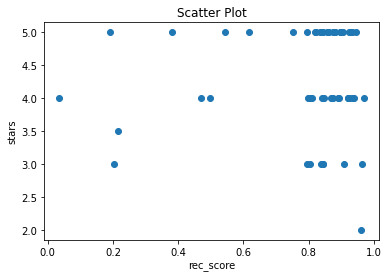

In [78]:
import matplotlib.pyplot as plt

# create scatter plot
plt.scatter(rec_summary['rec_score'],rec_summary['stars'])

# set plot title and labels
plt.title('Scatter Plot')
plt.xlabel('rec_score')
plt.ylabel('stars')

# show the plot
plt.show()

In [79]:
# plt.figure(figsize=(20, 8))
# plt.title("Number Of Contribution By Receipt Amount", fontsize=24)
# plt.xlabel("Receipt Amount", fontsize=14)
# plt.ylabel("Number Of Contribution", fontsize=14)
# plt.tick_params(axis='both', labelsize=12, color='darkblue')
# # plt.xticks(bin_range)

# plt.hist(rec_summary['rec_score'], facecolor='darkblue')

# (WIP) Item-based Algorithm and Content-based algorithm

In [80]:
rating_sites = combined_business_data[combined_business_data['user_id']==target_user].groupby('name').mean().sort_values(by='stars',ascending=False)
rating_sites['site_name'] = rating_sites.index

In [81]:
rating_sites_copy = rating_sites

In [82]:
rating_sites = rating_sites_copy

In [83]:
subset_business = business

In [84]:
# subset_business
subset_business[subset_business['name'].isin(rating_sites['site_name'])]
# subset_business[subset_business["name"].isin(rating_sites['site_name'].index)]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'RestaurantsGoodFor...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
652,kGjpBqAqG4mIuFSgU2KKEA,The Royal Indian Cuisine,272 S 20th St,Philadelphia,PA,19103,39.948365,-75.174500,4.0,28,1,"{'DogsAllowed': 'False', 'HasTV': 'False', 'Bu...","Restaurants, Indian","{'Monday': '16:0-22:0', 'Wednesday': '11:0-22:..."
821,JomDoQafikclSVVCPkWjnA,Cedar Park Cafe,4914 Baltimore Ave,Philadelphia,PA,19143,39.947960,-75.221980,4.0,301,1,"{'WiFi': 'u'no'', 'OutdoorSeating': 'False', '...","Diners, Restaurants, Sandwiches, Breakfast & B...","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."
1135,DOl21AqtT74dUZ3kvXNNcA,Golden Triangle,610 S 5th St,Philadelphia,PA,19147,39.941520,-75.150970,4.5,159,1,"{'Caters': 'True', 'HasTV': 'True', 'WiFi': ''...","Restaurants, Malaysian, Burmese, Asian Fusion,...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-22:0', ..."
1392,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,4618 Baltimore Ave,Philadelphia,PA,19143,39.948664,-75.215832,4.5,458,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Cafes, Pakistani, Juice Bars & Smoothies, Rest...","{'Monday': '12:0-22:0', 'Tuesday': '12:0-22:0'..."
1437,68ThEdiK0eWCEgGEmV9Tng,Southgate,1801 Lombard St,Philadelphia,PA,19146,39.945569,-75.171790,4.0,323,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Breakfast & Brunch, American (Traditional), Ko...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:0', ..."
1920,cLlBDZxYJ1dt1JgMuZnXew,Olly,700 S 5th St,Philadelphia,PA,19147,39.940878,-75.151106,4.0,51,1,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...","Pizza, Food, Bagels, Sandwiches, Comfort Food,...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-21:0'..."
2491,eqNutOMnPqKa9QDAY6KfEw,J'aime French Bakery,212 S 12th St,Philadelphia,PA,19107,39.948081,-75.160809,4.5,310,1,"{'BikeParking': 'True', 'Caters': 'True', 'Dog...","Food, Juice Bars & Smoothies, Coffee & Tea, Re...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-16:0', '..."
2619,7lwe7n-Yc-V9E_HfLAeylg,Pub & Kitchen,1946 Lombard St,Philadelphia,PA,19146,39.945657,-75.174773,3.5,615,1,"{'RestaurantsGoodForGroups': 'True', 'WiFi': '...","Restaurants, Pubs, Food, Bars, American (New),...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
2783,14ZGwnDyydXdSBsLXpSUrA,Vientiane Café,4728 Baltimore Ave,Philadelphia,PA,19143,39.948309,-75.217890,4.0,304,1,"{'BusinessAcceptsCreditCards': 'False', 'Outdo...","Vietnamese, Restaurants, Food, Thai, Coffee & ...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:0', ..."


In [85]:
recommend_restaurants_content_based(rating_sites.index[0],'Philadelphia','Philadelphia',subset_business,subset_review)

NameError: name 'recommend_restaurants_content_based' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


# Content-based Recommender
def recommend_restaurants_content_based(
    input_restaurant_name,
    my_city,
    dest_city,
    businesses,
    reviews,
    vectorizer=TfidfVectorizer(stop_words="english"),
    top_n=10,
):
    """
    This function recommends similar restaurants in a destination city based on a restaurant name in the user's current city.
    Parameters:
        - input_restaurant_name (str): The name of the restaurant in the user's current city that they would like to
                                       find similar restaurants in the destination city.
        - my_city (str): The city where the input restaurant is located.
        - dest_city (str): The city where the user wants to find similar restaurants.
        - businesses (pandas.DataFrame): A DataFrame that contains information about businesses,
                                         including their name and location.
        - reviews (pandas.DataFrame): A DataFrame that contains information about reviews for businesses,
                                      including the text of the review and the business it was left for.
        - vectorizer (TfidfVectorizer, optional): A TfidfVectorizer object that is used to vectorize the text of the
                                                  reviews. The default is a new instance of the TfidfVectorizer class.
        - top_n (int, optional): number of output to return. Default is 10.
    Returns:
        - pandas.DataFrame or str: Returns a DataFrame with columns 'name', 'business_id', 'categories', 'similarity_score', 'avg_rating', and 'city'
                                   if similar restaurants are found in the destination city.
            Returns a string if:
            - The input restaurant is not found in the source city.
            - No reviews are found for the target business.
            - No similar business is found in the destination city.
    """

    # Convert both the input and the names in the 'businesses' data to lowercase
    input_restaurant_name = input_restaurant_name.lower()
    businesses["name"] = businesses["name"].str.lower()
    businesses["city"] = businesses["city"].str.lower()

    # Filter the businesses data to only include those in the source city
    businesses_in_my_city = businesses[businesses["city"] == my_city.lower()]

    # Find the row in the 'businesses' data where the name matches the input
    target_business = businesses_in_my_city[
        businesses_in_my_city["name"] == input_restaurant_name
    ]
#     print('target_business:')
    display(target_business)

    # Check if there is a matching business name
    if target_business.empty:
        return "Business not found in source city"

    target_business_id = target_business.iloc[0]["business_id"]

    # Filter reviews data to only include reviews for the target business
    target_reviews = reviews[reviews["business_id"] == target_business_id]
#     print('Number of target reviews',target_reviews['business_id'].count())

    # Check if target_reviews is empty
    if target_reviews.empty:
        return "No reviews found for the target business"

    # Concatenate the text of all the reviews for the target business
    text = " ".join(review for review in target_reviews["text"])

    # Vectorize the text
    X = vectorizer.fit_transform([text])

    # Calculate cosine similarity
    cosine_similarities = cosine_similarity(X, X).flatten()

    # Find the indices of the most similar reviews (top 10 by default, minus the input review)
#     related_review_indices = cosine_similarities.argsort()[:-11:-1]
    related_review_indices = cosine_similarities.argsort()
    print(type(related_review_indices))
    print(related_review_indices)

    # Get the business_ids of the most similar reviews
    similar_business_ids = [
        reviews.iloc[index]["business_id"] for index in related_review_indices
    ]

    # Filter businesses data to only include the most similar businesses
    similar_businesses = businesses[
        businesses["name"].isin(rating_sites['site_name'])
    ]
    print('similar_businesses:')
    display(similar_businesses)

    # Remove the target business
    similar_businesses = similar_businesses[
        similar_businesses["business_id"] != target_business_id
    ]

    # Filter the 'categories' column to only include categories without 'Restaurants'
#     similar_businesses = similar_businesses
#     similar_businesses = similar_businesses[
#         ~similar_businesses["categories"].str.contains("Restaurants")
#     ]


    # Filter the businesses data to only include those in the destination city
    similar_businesses_in_dest_city = similar_businesses[
        similar_businesses["city"] == dest_city.lower()
    ]
    print('similar_businesses_in_dest_city:')
    display(similar_businesses_in_dest_city)
    
    # If there is no similiar businesses, return a string saying there is none
    if similar_businesses_in_dest_city.empty:
        return "No similar business found in destination city"

    # Get the cosine similarity scores for the most similar businesses
    similarity_scores = [
        cosine_similarities[related_review_indices[i]]
        for i in range(len(related_review_indices))
    ]

    # Get the average ratings
    avg_ratings = [
        reviews[reviews["business_id"] == business_id]["stars"].mean()
        for business_id in similar_business_ids
    ]

    # Create a table with business name, categories, and similarity score
    result = pd.DataFrame(
        {
            "name": similar_businesses["name"],
            "business_id": similar_business["business_id"],
            "city": similar_business["city"],
            "categories": similar_businesses["categories"],
            "similarity_score": similarity_scores,
            "avg_rating": avg_ratings,
        }
    )

    # Sort the table by similarity score in descending order
    result = result.sort_values(
        by=["similarity_score", "avg_rating"], ascending=[False, False]
    )

    return result.head(top_n)


# Item-basd Recommender
def recommend_restaurants_item_based(
    input_restaurant_name, my_city, dest_city, businesses, reviews, top_n=10
):
    """
    Given an input restaurant name and two cities, this function recommends similar restaurants in the destination city
    by comparing the categories of businesses. The similarity score and average rating of each restaurant is calculated,
    and the top top_n most similar and highly rated restaurants are returned.
    Parameters:
        - input_restaurant_name (str): The name of the input restaurant.
        - my_city (str): The city of the input restaurant.
        - dest_city (str): The destination city to recommend similar restaurants.
        - businesses (pandas.DataFrame): A DataFrame containing information about businesses,
                                         including business name, ID, city, and categories.
        - reviews (pandas.DataFrame): A DataFrame containing information about reviews, including business ID and rating.
        - top_n (int): The number of restaurants to recommend (default is 10).
    Returns:
        - pandas.DataFrame: A DataFrame containing the name, ID, categories, similarity score, and average rating
                            of the top top_n most similar and highly rated restaurants in the destination city.
    """

    # Convert the input restaurant name and the names in the 'businesses' data to lowercase
    input_restaurant_name = input_restaurant_name.lower()
    businesses["name"] = businesses["name"].str.lower()

    # Filter the businesses data to only include those in the user's city
    my_city_businesses = businesses[businesses["city"] == my_city]

    # Find the row in the 'businesses' data where the name matches the input
    target_business = my_city_businesses[
        my_city_businesses["name"] == input_restaurant_name
    ]

    # Check if there is a matching business name in the user's city
    if target_business.empty:
        return "Business not found in your city"

    target_business_id = target_business.iloc[0]["business_id"]

    # Filter the businesses data to only include those in the destination city
    dest_city_businesses = businesses[businesses["city"] == dest_city]

    # Create an empty list to store the similarity scores for each business
    similarity_scores = []

    # Loop through each business in the destination city
    for i, business in dest_city_businesses.iterrows():
        
        # Get the categories of the target business and the current business
        target_categories = set(target_business["categories"].iloc[0].split(", "))
        current_categories = set(business["categories"].split(", "))

        # Calculate the Jaccard similarity between the target business and the current business
        similarity_score = len(target_categories & current_categories) / len(
            target_categories | current_categories
        )

        # Store the similarity score for the current business
        similarity_scores.append((business["business_id"], similarity_score))

    # Sort the list of similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Filter the 'businesses' data to only include the most similar businesses
    similar_businesses = businesses[
        businesses["business_id"].isin([x[0] for x in similarity_scores])
    ]

    # Remove the target business
    similar_businesses = similar_businesses[
        similar_businesses["business_id"] != target_business_id
    ]

    # If there are no similar businesses in the destination city, return a message saying so
    if similar_businesses.empty:
        return "No similar businesses found in the destination city"

    # Create a list of business IDs for the most similar businesses in the destination city
    business_ids = similar_businesses["business_id"].tolist()

    # Get the average rating for each similar business
    avg_ratings = []
    for business_id in business_ids:
        ratings = reviews[reviews["business_id"] == business_id]["stars"].mean()
        avg_ratings.append((business_id, ratings))

    # Sort the list of average ratings in descending order
    avg_ratings = sorted(avg_ratings, key=lambda x: x[1], reverse=True)

    # Similarity score dictionary
    similarity_scores_dict = {x[0]: x[1] for x in similarity_scores}

    # Return the names of the most highly rated restaurants
    recommendations = []
    for business_id, avg_rating in avg_ratings:
        business = similar_businesses[
            similar_businesses["business_id"] == business_id
        ].iloc[0]
        recommendations.append(
            {
                "name": business["name"],
                "business_id": business["business_id"],
                "city": business["city"],
                "categories": [
#                     x for x in business["categories"].split(", ") if x != "Restaurants"
                    x for x in business["categories"].split(", ") if x = "Restaurants"
                ],
                "similarity_score": similarity_scores_dict[business_id],
                "avg_rating": avg_rating,
            }
        )

    df = pd.DataFrame(recommendations)
    df = df.sort_values(by=["similarity_score", "avg_rating"], ascending=[False, False])
    df.reset_index(drop=True, inplace=True)

    return df.head(top_n)



<a id="NN-keras"></a>
## 2. Neural Network Model - Keras

Finally, we’ll build a neural network and see how it compares to the other collaborative filtering approach. 

In [ ]:
# create the copy of combined_business_data table
combined_business_data_keras = combined_business_data.copy()
combined_business_data_keras.head(1)

We are using LabelEncoder from sklearn to encode business and user id's. We will create variables that store unique users, restaurants, min_rating, and max_rating.

In [ ]:
from sklearn.preprocessing import LabelEncoder

user_encode = LabelEncoder()

combined_business_data_keras['user'] = user_encode.fit_transform(combined_business_data_keras['user_id'].values)
n_users = combined_business_data_keras['user'].nunique()

item_encode = LabelEncoder()

combined_business_data_keras['business'] = item_encode.fit_transform(combined_business_data_keras['business_id'].values)
n_rests = combined_business_data_keras['business'].nunique()

combined_business_data_keras['stars'] = combined_business_data_keras['stars'].values#.astype(np.float32)

min_rating = min(combined_business_data_keras['stars'])
max_rating = max(combined_business_data_keras['stars'])

print(n_users, n_rests, min_rating, max_rating)

combined_business_data_keras

Split the data into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X = combined_business_data_keras[['user', 'business']].values
y = combined_business_data_keras['stars'].values

X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_keras.shape, X_test_keras.shape, y_train_keras.shape, y_test_keras.shape

In [ ]:
X_train_keras[:, 0]

We will need another variable that stores the number of factors per user/restaurant for the model. This number can be arbitrary. But for the Collaborative filtering model it needs to be the same size for both users and restaurants. 

Finally, we will store users and restaurants into separate arrays for the train and test set. It is because in Keras they’ll each be defined as distinct inputs.

In [ ]:
n_factors = 50

X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_test_array = [X_test_keras[:, 0], X_test_keras[:, 1]]

In [ ]:
X_train_array, X_test_array

Here, we’re going to use embeddings to represent each user and each restaurant in the data. To get these embeddings we need to do the dot product between the user vector and restaurant vector. As a result, we will have vectors of size n factors to capture the weights related to each user per restaurant. 

In order to increase the model performance, we add the "bias" to each embedding. We run the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. 

In [ ]:
from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x
    
def Recommender(n_users, n_rests, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_factors)(restaurant)
    mb = EmbeddingLayer(n_rests, 1)(restaurant)   
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)  
    
    model = Model(inputs=[user, restaurant], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)  
    
    return model

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# !pip uninstall keras

In [ ]:
# !pip install keras

In [ ]:
keras_model = Recommender(n_users, n_rests, n_factors, min_rating, max_rating)
keras_model.summary()

Let’s go ahead and train this for a few epochs and see what we get.

In [ ]:
keras_model.fit(x=X_train_array, y=y_train_keras, batch_size=64,\
                          epochs=5, verbose=1, validation_data=(X_test_array, y_test_keras))

<a id="prediction"></a>
* **Prediction**

After creating the model now it's time to predict the test dataset. 

In [ ]:
# prediction
predictions = keras_model.predict(X_test_array)

By creating the following table, we are able to see the model performance by comparing the actual stars and predictions.

In [ ]:
# create the df_test table with prediction results
df_test = pd.DataFrame(X_test_keras[:,0])
df_test.rename(columns={0: "user"}, inplace=True)
df_test['business'] = X_test_keras[:,1]
df_test['stars'] = y_test_keras
df_test["predictions"] = predictions
df_test.head()

In [ ]:
# Plotting the distribution of actual and predicted stars
import matplotlib.pyplot as plt
import seaborn as sns
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Histogram")
plt.legend()
plt.show()

In [ ]:
# # plot 
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(15,6))

# ax1 = sns.distplot(df_test['stars'], hist=False, color="r", label="Actual Value")
# sns.distplot(predictions, hist=False, color="g", label="model2 Fitted Values" , ax=ax1)

# plt.title('Actual vs Fitted Values for Restaurant Ratings')
# plt.xlabel('Stars')
# plt.ylabel('Proportion of Ratings')

# plt.show()
# plt.close()

<a id="cos-similarity"></a>
* **Cosine similarity**

We will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two restaurants. Therefore, we need to extract embedding layers from the Keras model to compute the cosine similarity by doing a dot product.

In [ ]:
# Extract embeddings
emb = keras_model.get_layer('embedding_3')
emb_weights = emb.get_weights()[0]

print("The shape of embedded weights: ", emb_weights.shape)
print("The length of embedded weights: ", len(emb_weights))

Each restaurant is now represented as a 50-dimensional vector. We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

Source:  https://towardsdatascience.com/building-a-recommendation-system-using-neural-network-embeddings-1ef92e5c80c9

In [ ]:
# normalize and reshape embedded weights
emb_weights = emb_weights / np.linalg.norm(emb_weights, axis = 1).reshape((-1, 1))
len(emb_weights)

In [ ]:
# get all unique business_ids (restaurants)
rest_id_emb = combined_business_data_keras["business_id"].unique()
len(rest_id_emb)

We are going to create a table that contains all the unique restaurants in 50 dimensions with their embedded weights.

In [ ]:
rest_pd = pd.DataFrame(emb_weights)
rest_pd["business_id"] = rest_id_emb
rest_pd = rest_pd.set_index("business_id")
rest_pd

In [ ]:
# merging rest_pd and temp tables to get the name of the restaurants.
temp = combined_business_data_keras[['business_id', 'name']].drop_duplicates()
df_recommend = pd.merge(rest_pd, temp, on='business_id')
df_recommend

<a id="recommendation"></a>
* **Recommendation**

Now we going to use this model to recommend restaurants to a popular restaurant which was "Wvrst".

In [ ]:
# exrtract the target restaurant from the df_recommend table
target = df_recommend[df_recommend['name'] == 'Wvrst']
target.iloc[:,1:51]

We are creating a function that calculates the cosine similarity between the target and the rest of the other restaurants and returns the table with the result.

In [ ]:
def find_similarity_total(rest_name):
    """Recommends restaurant based on the cosine similarity between restaurants"""
    cosine_list_total = []
    result = []

    for i in range(0, df_recommend.shape[0]):
        sample_name = df_recommend[df_recommend["name"] == rest_name].iloc[:,1:51]
        row = df_recommend.iloc[i,1:51]
        cosine_total = np.dot(sample_name, row)
        
        recommended_name = df_recommend.iloc[i,51]
        cosine_list_total.append(cosine_total)
        result.append(recommended_name)
        
    cosine_df_total = pd.DataFrame({"similar_rest" : result, "cosine" : cosine_list_total})

    return cosine_df_total

In [ ]:
# call the function with input of "Wvrst" and store it in result variable.
result = find_similarity_total('Wvrst')

In [ ]:
# head of result table
result.head()

We created the following function to get rid of the "[ ]" in "cosine" column.

In [ ]:
'''
- function that replace '[]' to empty str 
- convert string to float
'''
def convert(input):
    return float(str(input).replace('[','').replace(']',''))

In [ ]:
# create new column called "cos" in result table
result['cos'] = result.apply(lambda x: convert(x['cosine']), axis=1)

# drop original 'cosine' column (which had values with np.array)
result.drop('cosine', axis=1, inplace=True)

# sort values with cos
result.sort_values('cos', ascending=False).head(10)